In [23]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
import xgboost as xgb
import numpy as np

In [3]:
import os
path = os.path.dirname(xgb.__file__)
print(path)

/home/agavrilenko/anaconda3/lib/python3.6/site-packages/xgboost


In [4]:
#help(xgboost.training.train)
help(xgb.train)

Help on function train in module xgboost.training:

train(params, dtrain, num_boost_round=10, evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
    Train a booster with given parameters.
    
    Parameters
    ----------
    params : dict
        Booster params.
    dtrain : DMatrix
        Data to be trained.
    num_boost_round: int
        Number of boosting iterations.
    evals: list of pairs (DMatrix, string)
        List of items to be evaluated during training, this allows user to watch
        performance on the validation set.
    obj : function
        Customized objective function.
    feval : function
        Customized evaluation function.
    maximize : bool
        Whether to maximize feval.
    early_stopping_rounds: int
        Activates early stopping. Validation error needs to decrease at least
        every **early_stopping_rounds** round(s) to cont

In [14]:
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split # Model evaluation
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler # Preprocessing
from sklearn.linear_model import Lasso, Ridge, ElasticNet, RANSACRegressor, SGDRegressor, HuberRegressor, BayesianRidge # Linear models
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor  # Ensemble methods
from xgboost import XGBRegressor, plot_importance # XGBoost
from sklearn.svm import SVR, SVC, LinearSVC  # Support Vector Regression
from sklearn.tree import DecisionTreeRegressor # Decision Tree Regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline # Streaming pipelines
from sklearn.decomposition import KernelPCA, PCA # Dimensionality reduction
from sklearn.feature_selection import SelectFromModel # Dimensionality reduction
from sklearn.model_selection import learning_curve, validation_curve, GridSearchCV # Model evaluation
from sklearn.base import clone # Clone estimator
from sklearn.metrics import mean_squared_error as MSE
import xgboost as xgb

In [15]:
# load data
import pandas as pd
df_usa = pd.read_csv('data/houses/housesalesprediction/kc_house_data.csv', delimiter=",")

dataset.head()


df_usa.drop(['id', 'date'], axis=1, inplace=True)
X = df_usa.drop("price",axis=1).values
y = df_usa["price"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=3)

# split data into X and y
# X = dataset[:,0:8]
# Y = dataset[:,8]
# # split data into train and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=6)

In [131]:
dtrain = xgb.DMatrix(data = X_train, label = y_train, silent= True)

deval = xgb.DMatrix(data = X_test, label = y_test, silent= True)
# evals_list = []
# evals_list.append((deval, "eval matrix"))
num_epochs = 1000
params = {}
params['num_boost_round'] = num_epochs
params['early_stopping_rounds'] = 1000
#params['verbose_eval'] = 1
params['eval_metric'] = 'rmse'
params['evals_result'] = {}
params['max_depth'] = 3




In [132]:
learning_rates = []
tresholds = []
learning_rates.append(0.1)
counter = 0
best = []
progress = dict()
wait = []
def reduceLRonPlateau(i,n):

    factor = 0.5
    min_lr = 1e-15
    min_delta = 20
    patience = 10
    verbose = 0
    cooldown = 0
    cooldown_counter = 0  # Cooldown counter.
    
    #best = 0
    mode = 'min'  
    monitor_op = None
    old_lr = learning_rates[0]
    new_lr = learning_rates[0] 
    
    def in_cooldown():
            return cooldown_counter > 0
    
    def _reset(mode):
        """Resets wait counter and cooldown counter."""
#         if mode not in ['auto', 'min', 'max']:
#             warnings.warn('Learning Rate Plateau Reducing mode %s is unknown, '
#                           'fallback to auto mode.' % (mode),
#                           RuntimeWarning)
#             mode = 'auto'
#         if (mode == 'min' or
#            (mode == 'auto' and 'acc' not in monitor)):
#             monitor_op = lambda a, b: np.less(a, b - min_delta)
#             best = np.Inf
#         else:
#             monitor_op = lambda a, b: np.greater(a, b + min_delta)
#             best = -np.Inf
            
        cooldown_counter = 0
        del wait[:]
        return wait, cooldown_counter
    
    def checker(wait,best, new_lr, learning_rates):
        if (i == 0):
            wait, counter = _reset(mode)
            print("initialization...")
            print("lr: ", learning_rates[0])
            best.append(100000000)
            
        if (i>0):
            old_lr = learning_rates[i-1]
            #new_lr = learning_rates[i-1]
            current = progress['eval']['rmse'][i-1]
            if in_cooldown():
                cooldown_counter -= 1
                del wait[:]
              
            print("iter: ", i, " Current_loss: ", current, "best: ", best[i-1])
            if np.less(current, best[i-1] - min_delta):
                best.append(current)
                del wait[:]
             
            elif not in_cooldown():
                #rint("not in_cooldown")
                best.append(best[-1])
                wait.append(1)
                if len(wait) >= patience:
                    
                    if old_lr > min_lr:
                        new_lr = old_lr * factor
                        new_lr = max(new_lr, min_lr)
                        print("iter: ", i, "reducing lr -- ", " old_lr: ", old_lr, " new_lr: ", new_lr)
                        
#                         if self.verbose > 0:
#                             print('\nEpoch %05d: ReduceLROnPlateau reducing '
#                                   'learning rate to %s.' % (epoch + 1, new_lr))
                        cooldown_counter = cooldown
                        del wait[:]
        return new_lr


       # print("step ",progress['train']['logloss'][i-1], "i = ", i)

            
    
    new_lr = checker(wait,best,new_lr,learning_rates)
    learning_rates.append(new_lr)
        
    return new_lr

In [133]:

def run_gbm(dtrain, dvalid, param, evals_result, learning_rate):
    # check training arguments in param
    n_round = param.get('num_boost_round', 100)
    early_stop = param.get('early_stopping_rounds', 0)
    verbose_eval = param.get('verbose_eval', 50)
    # specify validations set to watch performance
    watchlist = [(dtrain,'train') ,(deval,'eval')]
    #callbacks_list = [learning_rates]

    bst = xgb.train(params=param,
            dtrain=dtrain,
            num_boost_round=n_round,
            evals=watchlist,
            early_stopping_rounds=early_stop,
            verbose_eval = verbose_eval,
            evals_result = evals_result, 
            callbacks = [xgb.callback.reset_learning_rate(reduceLRonPlateau)])
                   
    return bst 

In [134]:
model1 = run_gbm(dtrain, deval, params,progress, learning_rate = 0.1)

initialization...
lr:  0.1
[0]	train-rmse:597658	eval-rmse:590266
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 1000 rounds.
iter:  1  Current_loss:  590265.5 best:  100000000
iter:  2  Current_loss:  539130.9375 best:  590265.5
iter:  3  Current_loss:  493740.15625 best:  539130.9375
iter:  4  Current_loss:  453324.34375 best:  493740.15625
iter:  5  Current_loss:  417079.59375 best:  453324.34375
iter:  6  Current_loss:  385368.84375 best:  417079.59375
iter:  7  Current_loss:  357464.09375 best:  385368.84375
iter:  8  Current_loss:  332269.125 best:  357464.09375
iter:  9  Current_loss:  310484.65625 best:  332269.125
iter:  10  Current_loss:  290920.0 best:  310484.65625
iter:  11  Current_loss:  273306.21875 best:  290920.0
iter:  12  Current_loss:  258614.453125 best:  273306.21875
iter:  13  Current_loss:  245829.46875 best:  258614.453125
iter:  14  Current_loss:  233888.078125 best:  245829.

iter:  135  Current_loss:  121011.234375 best:  121107.046875
iter:  136  Current_loss:  121005.46875 best:  121011.234375
iter:  137  Current_loss:  120957.53125 best:  121011.234375
iter:  138  Current_loss:  120903.921875 best:  120957.53125
iter:  139  Current_loss:  120814.71875 best:  120903.921875
iter:  140  Current_loss:  120776.023438 best:  120814.71875
iter:  141  Current_loss:  120747.125 best:  120776.023438
iter:  142  Current_loss:  120673.234375 best:  120747.125
iter:  143  Current_loss:  120617.757812 best:  120673.234375
iter:  144  Current_loss:  120559.195312 best:  120617.757812
iter:  145  Current_loss:  120514.46875 best:  120559.195312
iter:  146  Current_loss:  120392.351562 best:  120514.46875
iter:  147  Current_loss:  120090.507812 best:  120392.351562
iter:  148  Current_loss:  120051.8125 best:  120090.507812
iter:  149  Current_loss:  120039.710938 best:  120051.8125
iter:  150  Current_loss:  120093.492188 best:  120051.8125
[150]	train-rmse:108866	eva

iter:  268  Current_loss:  115893.296875 best:  115902.242188
iter:  269  Current_loss:  115919.476562 best:  115902.242188
iter:  270  Current_loss:  115887.273438 best:  115902.242188
iter:  271  Current_loss:  115909.515625 best:  115902.242188
iter:  272  Current_loss:  115890.6875 best:  115902.242188
iter:  273  Current_loss:  115876.273438 best:  115902.242188
iter:  274  Current_loss:  115841.976562 best:  115876.273438
iter:  275  Current_loss:  115760.210938 best:  115841.976562
iter:  276  Current_loss:  115738.195312 best:  115760.210938
iter:  277  Current_loss:  115684.4375 best:  115738.195312
iter:  278  Current_loss:  115688.367188 best:  115684.4375
iter:  279  Current_loss:  115675.804688 best:  115684.4375
iter:  280  Current_loss:  115596.445312 best:  115684.4375
iter:  281  Current_loss:  115594.835938 best:  115596.445312
iter:  282  Current_loss:  115596.84375 best:  115596.445312
iter:  283  Current_loss:  115574.796875 best:  115596.445312
iter:  284  Current

iter:  400  Current_loss:  113377.0 best:  113395.039062
[400]	train-rmse:91872.1	eval-rmse:113352
iter:  401  Current_loss:  113351.726562 best:  113395.039062
iter:  402  Current_loss:  113387.84375 best:  113351.726562
iter:  403  Current_loss:  113410.460938 best:  113351.726562
iter:  404  Current_loss:  113398.625 best:  113351.726562
iter:  405  Current_loss:  113346.664062 best:  113351.726562
iter:  406  Current_loss:  113335.179688 best:  113351.726562
iter:  407  Current_loss:  113321.617188 best:  113351.726562
iter:  408  Current_loss:  113319.851562 best:  113321.617188
iter:  409  Current_loss:  113310.296875 best:  113321.617188
iter:  410  Current_loss:  113305.875 best:  113321.617188
iter:  411  Current_loss:  113299.085938 best:  113321.617188
iter:  412  Current_loss:  113275.460938 best:  113299.085938
iter:  413  Current_loss:  113250.492188 best:  113275.460938
iter:  414  Current_loss:  113207.210938 best:  113250.492188
iter:  415  Current_loss:  113191.765625

iter:  533  Current_loss:  111265.46875 best:  111286.84375
iter:  534  Current_loss:  111250.710938 best:  111265.46875
iter:  535  Current_loss:  111273.09375 best:  111265.46875
iter:  536  Current_loss:  111313.554688 best:  111265.46875
iter:  537  Current_loss:  111280.15625 best:  111265.46875
iter:  538  Current_loss:  111289.359375 best:  111265.46875
iter:  539  Current_loss:  111289.570312 best:  111265.46875
iter:  540  Current_loss:  111272.851562 best:  111265.46875
iter:  541  Current_loss:  111269.539062 best:  111265.46875
iter:  542  Current_loss:  111294.882812 best:  111265.46875
iter:  543  Current_loss:  111297.546875 best:  111265.46875
iter:  543 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  544  Current_loss:  111294.789062 best:  111265.46875
iter:  545  Current_loss:  111276.351562 best:  111265.46875
iter:  546  Current_loss:  111261.632812 best:  111265.46875
iter:  547  Current_loss:  111265.976562 best:  111265.46875
iter:  548  Current_loss:  11125

iter:  660  Current_loss:  110732.226562 best:  110745.828125
iter:  661  Current_loss:  110731.34375 best:  110745.828125
iter:  662  Current_loss:  110708.351562 best:  110745.828125
iter:  663  Current_loss:  110689.375 best:  110708.351562
iter:  664  Current_loss:  110669.460938 best:  110708.351562
iter:  665  Current_loss:  110671.71875 best:  110669.460938
iter:  666  Current_loss:  110672.789062 best:  110669.460938
iter:  667  Current_loss:  110675.734375 best:  110669.460938
iter:  668  Current_loss:  110673.429688 best:  110669.460938
iter:  669  Current_loss:  110675.25 best:  110669.460938
iter:  670  Current_loss:  110643.953125 best:  110669.460938
iter:  671  Current_loss:  110649.789062 best:  110643.953125
iter:  672  Current_loss:  110671.960938 best:  110643.953125
iter:  673  Current_loss:  110668.484375 best:  110643.953125
iter:  674  Current_loss:  110681.890625 best:  110643.953125
iter:  675  Current_loss:  110679.351562 best:  110643.953125
iter:  676  Curre

iter:  786  Current_loss:  110355.625 best:  110301.398438
iter:  787  Current_loss:  110352.8125 best:  110301.398438
iter:  788  Current_loss:  110316.148438 best:  110301.398438
iter:  789  Current_loss:  110294.203125 best:  110301.398438
iter:  790  Current_loss:  110278.539062 best:  110301.398438
iter:  791  Current_loss:  110283.8125 best:  110278.539062
iter:  792  Current_loss:  110304.820312 best:  110278.539062
iter:  793  Current_loss:  110308.3125 best:  110278.539062
iter:  794  Current_loss:  110274.46875 best:  110278.539062
iter:  795  Current_loss:  110240.515625 best:  110278.539062
iter:  796  Current_loss:  110220.796875 best:  110240.515625
iter:  797  Current_loss:  110227.460938 best:  110240.515625
iter:  798  Current_loss:  110190.640625 best:  110240.515625
iter:  799  Current_loss:  110183.859375 best:  110190.640625
iter:  800  Current_loss:  110176.992188 best:  110190.640625
[800]	train-rmse:80117.3	eval-rmse:110147
iter:  801  Current_loss:  110147.3593

iter:  912  Current_loss:  110059.046875 best:  110030.734375
iter:  913  Current_loss:  110052.710938 best:  110030.734375
iter:  913 reducing lr --   old_lr:  0.1  new_lr:  0.05
iter:  914  Current_loss:  110040.40625 best:  110030.734375
iter:  915  Current_loss:  110013.148438 best:  110030.734375
iter:  916  Current_loss:  110005.242188 best:  110030.734375
iter:  917  Current_loss:  110007.429688 best:  110005.242188
iter:  918  Current_loss:  110013.09375 best:  110005.242188
iter:  919  Current_loss:  110025.25 best:  110005.242188
iter:  920  Current_loss:  110026.695312 best:  110005.242188
iter:  921  Current_loss:  109995.726562 best:  110005.242188
iter:  922  Current_loss:  109994.5 best:  110005.242188
iter:  923  Current_loss:  109978.554688 best:  110005.242188
iter:  924  Current_loss:  109993.921875 best:  109978.554688
iter:  925  Current_loss:  109974.421875 best:  109978.554688
iter:  926  Current_loss:  109972.992188 best:  109978.554688
iter:  927  Current_loss:

In [135]:
# fit model no training data
model = XGBRegressor(n_estimators=num_epochs, learning_rate=0.1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "rmse"], eval_set=eval_set, verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

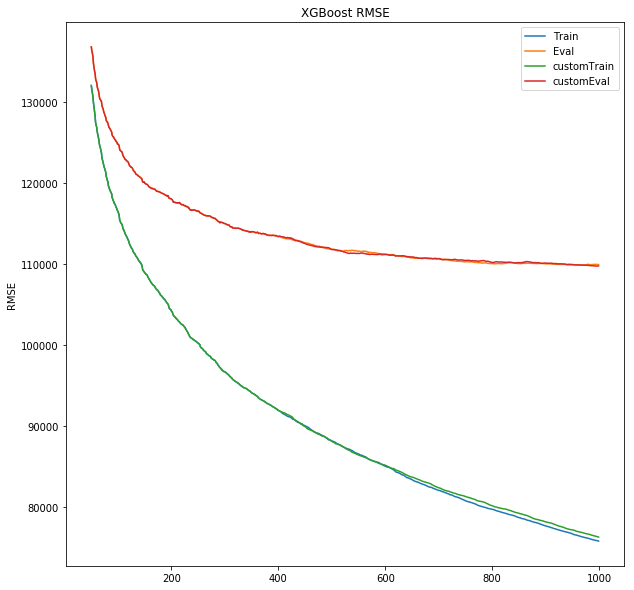

iter:  995  min customEval: 109695.023438
iter:  972  min Eval: 109787.789062


In [136]:
# retrieve performance metrics
results = model.evals_result()
#results1 = model1.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(50, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(10, 10))
ax.plot(x_axis, results['validation_0']['rmse'][50::], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'][50::], label='Eval')
ax.plot(x_axis, progress['train']['rmse'][50::], label = 'customTrain')
ax.plot(x_axis, progress['eval']['rmse'][50::], label = 'customEval')
ax.legend()
pyplot.ylabel('RMSE')
pyplot.title('XGBoost RMSE')

pyplot.show()
print("iter: ", progress['eval']['rmse'].index(min(progress['eval']['rmse'])), " min customEval:", min(progress['eval']['rmse']))
print("iter: ", results['validation_1']['rmse'].index(min(results['validation_1']['rmse'])), " min Eval:", min(results['validation_1']['rmse']))

In [137]:
# plot classification error
# fig, ax = pyplot.subplots()
# ax.plot(x_axis, results['validation_0']['error'][25::], label='Train')
# ax.plot(x_axis, results['validation_1']['error'][25::], label='Test')
# ax.legend()
# pyplot.ylabel('Classification Error')
# pyplot.title('XGBoost Classification Error')
# pyplot.show()